In [38]:
"""In this notebook, we build a logistic regression model class from scratch. 
This differs from sklearn's model in that it accepts pandas dataframes + column names as 
inputs, as opposed to arrays. Once we have built this, we test the model on sklearn data
to ensure it is working as expected, before testing the model on a subset of the 
SBA loan datset."""

"In this notebook, we build a logistic regression model class from scratch. \nThis differs from sklearn's model in that it accepts pandas dataframes + column names as \ninputs, as opposed to arrays. Once we have built this, we test the model on sklearn data\nto ensure it is working as expected, before testing the model on a subset of the \nSBA loan datset."

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [40]:
class LogisticRegressionDf:

    def __init__(self):
        self.coef = None  # Coefficients of linear portion of model
        self.feature_ls = None  # List of feature columns
        self.target_str = None  # Name of target column
        self.is_fitted = False  # True if model has been fit
        self.features = None  # Normalised numpy array of model features (for fitting)
        self.target = None  # Numpy array of binary target variable
        self.fitted = None  # Model predictions for training data
        self.predicted = None  # Prediction of model on testing data
        self.loss_list = None  # Tracks loss through gradient descent during regression
        self.predict_proba = None  # List of model probabilities following prediction

    def __repr__(self):
        return "Logistic regression model for pandas dataframes"

    # Sigmoid function
    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(- z))

    @staticmethod
    def initialise(x, df):
        """Converts feature columns to a numpy array and normalises them.
        Arguments:
            x: list of column names acting as features
            df: dataframe containing raw data."""
        x = np.array(df[x])
        for i in range(np.shape(x)[1]):
            x[:, i] = (x[:, i] - np.mean(x[:, i])) / np.std(x[:, i])
        if len(x.shape) == 1:
            x = x.reshape(-1, 1)
        return x

    # Converting set of pandas dataframe columns to np array. # EXPAND ON COMMENT
    def data_ingest(self, df, x=None, y=None):
        """Converts data stored in a pandas dataframe to numpy arrays for fitting/predicting.
        Arguments:
            df: pandas dataframe, including both feature and target columns
            x: A list of dataframe columns acting as features
            y: Name of the column acting as the target """
        assert (
            isinstance(df, pd.DataFrame)
        ), "df must be the pandas training dataframe"

        if x is not None:
            assert (
                isinstance(x, list)
            ), "x should be a list of feature columns"

            self.feature_ls = df[x].columns.values.tolist()
            x = self.initialise(x, df)
            self.features = x

        if y is not None:
            assert (
                isinstance(y, str)
            ), "y should be the name of the target column (type str)"

            self.target_str = y
            y = np.array(df[y])
            self.target = y

    # Fitting model
    def fit(self, df, x=None, y=None, learning_rate=0.001, n_iter=400, threshold=0.5):
        """Fits logistic regression model. Arguments:
            df: Dataframe where the features and target are stored
            x: list of column names acting as features
            y: name of target model
            learning_rate, n_iter: values for gradient descent
            threshold: threshold value for model fitting the training features
            Note: we keep x=None, y=None possibilities for when data_ingest was called before fit"""

        self.data_ingest(df, x, y)

        if self.features is None:
            print("Please specify a list of feature columns")
            return None
        if self.target is None:
            print("Please specify the name of the target column")
            return None

        x, y = self.features, self.target

        # Adding extra column to predictor matrix to account for intercept term
        coef = np.zeros((np.shape(x)[1] + 1, 1))
        x = np.c_[np.ones((np.shape(x)[0], 1)), x]

        # Defining loss function
        def loss(theta, eps=1e-5):  # eps to avoid zero arguments in the log
            z = np.dot(x, theta)
            loss0 = np.dot(y.T, np.log(self.sigmoid(z) + eps))  # -Cost if y = 1
            loss1 = np.dot((1 - y).T, np.log(1 - self.sigmoid(z) + eps))  # -Cost if y = 0
            return - (loss1 + loss0) / len(y)  # Dividing by number of losses

        # Gradient descent
        loss_ls = np.zeros(n_iter)
        for i in range(n_iter):
            coef = coef - learning_rate * np.dot(x.T, self.sigmoid(np.dot(x, coef))
                                                 - np.reshape(y, (len(y), 1)))
            loss_ls[i] = loss(coef)

        self.coef = coef
        self.loss_list = loss_ls
        self.is_fitted = True

        # Predicting known y values using model
        fitted = []
        for i in self.sigmoid(np.dot(x, coef)):
            if i > threshold:
                fitted.append(1)
            else:
                fitted.append(0)
        self.fitted = fitted

    def descent_plotter(self):
        """Plots loss as a function of iteration, for checking whether the model achieves gradient descent"""

        if not self.is_fitted:
            print("Model not yet fitted.")
            return None

        y_vals = self.loss_list
        x_vals = [i for i in range(len(y_vals))]

        f, ax = plt.subplots()
        plt.scatter(x_vals, y_vals)

        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.set_title("Gradient descent")

        plt.show()

    def predict(self, df, x=None, threshold=0.5, probabilities=False):
        """Performs prediction. Arguments:
            df: testing/validating dataframe
            x: list of columns acting as features. If None, use column list from fitting
            threshold: when to cutoff.
            probabilities: if True, returns a list of model probabilities"""

        if not self.is_fitted:
            print("Model not yet fitted.")
            return None

        if x is None:
            x = self.feature_ls

        x = self.initialise(x, df)
        z = np.dot(np.c_[np.ones((np.shape(x)[0], 1)), x], self.coef)
        self.predict_proba = self.sigmoid(z)

        predictions = []
        for i in self.predict_proba:
            if i >= threshold:
                predictions.append(1)
            else:
                predictions.append(0)

        self.predicted = predictions

        if probabilities:
            return self.predict_proba
        return self.predicted

    def scores(self, df, y_true=None, y_pred=None, accuracy=False, precision=False,
               recall=False, f1_score=False, score_matrix=False):
        """Returns accuracy/precision/recall/F1 score of model.
        Arguments:
            df: dataframe containing true values for y
            y_true: string of target column. If None, use name of target column used for fitting
            y_pred: list of predicted y values. If None, use predicted values from prediction already ran
            accuracy: if True, return accuracy
            precision: if True, return precision
            recall: if True, return recall
            f1_score: if True, return F1 score
            score_matrix: if True, return matrix of all four scores"""

        if y_true is None:
            y_true = self.target_str

        y_true = np.array(df[y_true]).reshape(-1, 1)

        if y_pred is None:
            if self.predicted is None:
                print("Model prediction not yet ran. Please do this, or specify a list of predicted values")
                return None
            y_pred = self.predicted

        if not any([accuracy, precision, recall, f1_score, score_matrix]):
            print("Please specify a score metric")
            return None

        if sum([accuracy, precision, recall, f1_score, score_matrix]) > 1:
            print("Please specify at most one score, or specify score_matrix to get all four scores")
            return None

        tp, tn, fp, fn = 0, 0, 0, 0
        for i in range(len(y_true)):
            if y_true[i] == 1 and y_pred[i] == 1:
                tp += 1
            elif y_true[i] == 0 and y_pred[i] == 0:
                tn += 0
            elif y_true[i] == 1 and y_pred[i] == 0:
                fn += 1
            elif y_true[i] == 0 and y_pred[i] == 1:
                fp += 1

        acc = (tp + tn) / (tp + fp + tn + fn)
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        f1 = 2 * prec * rec / (prec + rec)
        score_mat = np.array([['Accuracy: ' + str(acc), 'Precision: ' + str(prec)],
                              ['Recall: ' + str(rec), 'F1 Score: ' + str(f1)]])

        if accuracy:
            return acc
        if precision:
            return prec
        if recall:
            return rec
        if f1_score:
            return f1
        return score_mat

In [41]:
# Testing class on sklearn data, and comparing it to sklearn's 
# built-in logistic regression model
from sklearn.datasets import make_classification
p, q = make_classification(n_features=4)

In [42]:
# Converting data to dataframe
feature_list = ['f1', 'f2', 'f3', 'f4']
df4 = pd.DataFrame(np.hstack((p, q.reshape(-1, 1))), columns=feature_list + ['target'])
df_tr, df_te = train_test_split(df4, train_size=0.8, test_size=0.2)

In [43]:
# Fitting model
model = LogisticRegressionDf()
model.fit(df_tr, x=feature_list, y='target')
print(model.scores(df_tr, y_pred=model.fitted, f1_score=True))
model.predict(df_te)
print(model.scores(df_te, f1_score=True)) 
# Good F1 score

0.9500000000000001
0.9600000000000001


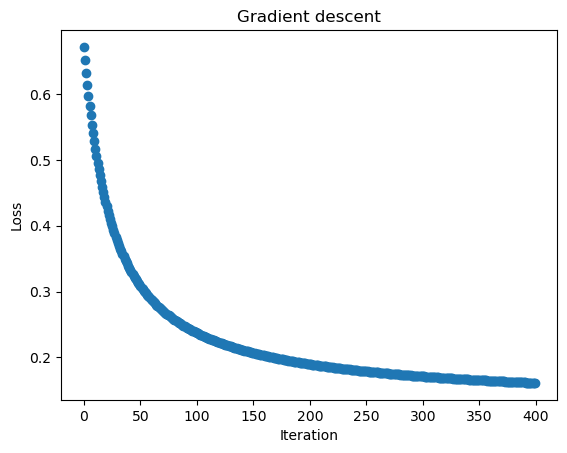

In [44]:
# Checking if descent plotter works
model.descent_plotter()
# It seems to be

In [45]:
# Comparing to sklearn's model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

model2 = LogisticRegression()
p_tr, p_te, q_tr, q_te = train_test_split(p, q, train_size=0.8, test_size=0.2)
model2.fit(p_tr, q_tr)
print(f1_score(q_tr, model2.predict(p_tr)))
print(f1_score(q_te, model2.predict(p_te)))
# Same as ours!

0.9500000000000001
0.9600000000000001


In [46]:
# Now it's time to test the model on our data. Extracting dataframe:
loan_df = pd.read_csv('SBANational_regr.csv', dtype={'ApprovalDate': str, 'DisbursementDate': str},
                      parse_dates=['ApprovalDate', 'DisbursementDate'])

In [47]:
"""Although we identified Industry and State as potential risk indicators, 
the inclusion of 50 state and 20 industry classifications could cause problems. Thus, we restrict the dataset to the state of
Texas and the industry 'Retail trade'."""

"Although we identified Industry and State as potential risk indicators, \nthe inclusion of 50 state and 20 industry classifications could cause problems. Thus, we restrict the dataset to the state of\nTexas and the industry 'Retail trade'."

In [48]:
loan_df = loan_df[(loan_df.State == 'TX') & (loan_df.Industry == 'Retail trade')]
print(len(loan_df))
# We still have sufficient data for the model to run well.

9292


In [49]:
"""We will now select model coefficients. We will pick 4 datapoints which correlated strongly
with MIS_Status (DisbursementGross, RealEstate, Recession, Portion) and one which didn't
(NewExist) for validation purposes."""

"We will now select model coefficients. We will pick 4 datapoints which correlated strongly\nwith MIS_Status (DisbursementGross, RealEstate, Recession, Portion) and one which didn't\n(NewExist) for validation purposes."

In [50]:
feat_ls = ['NewExist', 'Portion', 'Recession', 'RealEstate', 'DisbursementGross']
loan_df = loan_df[feat_ls + ['Default']]

In [51]:
# Initialising model and ingesting training data
loan_model = LogisticRegressionDf()
loan_df_tr, loan_df_te = train_test_split(loan_df, train_size=0.5, test_size=0.5)
loan_model.data_ingest(loan_df_tr, feat_ls, 'Default')

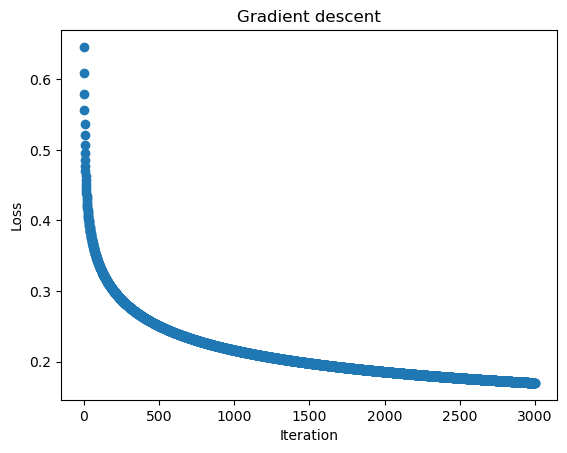

In [52]:
# Fitting and checking descent.
loan_model.fit(loan_df_tr, n_iter=3000, learning_rate=0.0001)
loan_model.descent_plotter()
# Good so far!

In [53]:
# Predicting and obtaining F1 score from testing data
loan_model.predict(loan_df_te, probabilities=True)
print('F1 score :' + str(loan_model.scores(loan_df_te, f1_score=True)))
# Good F1 score!

F1 score :0.871124031007752


In [54]:
"""As mentioned above, we will now drop NewExist as one of the feature columns, and see if 
the model is at all affected."""

'As mentioned above, we will now drop NewExist as one of the feature columns, and see if \nthe model is at all affected.'

In [55]:
loan_df_2 = loan_df.copy(deep=True)
feat_ls_2 = feat_ls[1:]
loan_df_2 = loan_df_2.drop(columns=['NewExist'])
loan_model_2 = LogisticRegressionDf()
loan_df_tr_2, loan_df_te_2 = train_test_split(loan_df_2, train_size=0.5, test_size=0.5)
loan_model_2.data_ingest(loan_df_tr_2, feat_ls_2, 'Default')
loan_model_2.fit(loan_df_tr_2, n_iter=3000, learning_rate=0.0001)
loan_model_2.predict(loan_df_te_2, probabilities=True)
print('F1 score: ' + str(loan_model_2.scores(loan_df_te_2, f1_score=True)))
# The F1 score is still high!

F1 score: 0.8548155246765692
